In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import curve_fit

In [2]:
"""
the code in this cell searches the directory of the notebook 
for files ending with .dat, which are the data files
"""
import glob
    
files = (glob.glob('*.dat'))
print(files, len(files)) #checking if the code worked   

['AN_Aur_p.dat', 'CH_Cas_p.dat', 'ER_Aur_p.dat', 'FM_Aql_p.dat', 'GV_Aur_p.dat', 'IN_Aur_p.dat', 'KK_Cas_p.dat', 'RS_Cas_p.dat', 'RX_Aur_p.dat', 'RY_Cas_p.dat', 'SW_Cas_p.dat', 'SY_Aur_p.dat', 'SY_Cas_p.dat', 'SZ_Aql_p.dat', 'TT_Aql_p.dat', 'U_Aql_p.dat', 'VW_Cas_p.dat', 'YZ_Aur_p.dat'] 18


In [3]:
#defining the function to be fit later using scipy.curve_fit
def func(x, a, b, c, d):
    return a*np.sin((2*np.pi/b)*x+c)+d 

In [4]:
class cepheid: 
    
    def __init__(self, name = None):
        aur = np.genfromtxt(name, usecols = (0, 1), invalid_raise = False) 
        self.relT = aur[:,0]
        self.mag = aur[:,1]
        self.name= name #defining all the variables
    
        """
    defining the power spectrum here. even if you find the peaks, it is hard to
    know which one is the correct one: the highest one does not necessarely 
    indicate the period of the system!
    """
    def powerSpectrum(self):
        self.periods = np.linspace(3, 28, num = 1000) #generating the necessary variables. num in linspace indicates how many power_spectrum points you want to calculate
        self.power = np.zeros(len(self.periods))
        index = 0
        for period in self.periods:
            self.power[index] = 0
            for _t,_mag in zip(self.relT,self.mag):
                self.power[index] += _mag * np.cos(2*np.pi*_t/period)
            index += 1
        self.power = (2*self.power/len(self.periods))**2
        return self.power
        
    def power_spectrum_peaks(self):
        self.power = self.powerSpectrum()
        self.peaks = signal.find_peaks_cwt(self.power, np.arange(1, 28)) #np.arange gives all the possible widths of the peaks. lowering the number increases the number of peaks found
        
        return self.peaks

    def power_spectrum_plot(self):
        self.power_spectrum_peaks()
        print ('peaks are at ', self.periods[self.peaks])

        plt.scatter(self.periods, self.power)
        plt.title(self.name)
        plt.show() #showing the power spectrums and the found peaks for comparison
    
    
    def parameter_estimation(self):
        self.time = np.linspace(self.relT.min(), self.relT.max(), 150)
        self.peaks = self.power_spectrum_peaks()
        covsum = 1e1000 #some obsenely large number for later check
        optimised = []
        """
        the for loop below goes through all the peaks in peakdict and tries
        to find the one with minimised pcov matrix diagonal. chi-sq test might
        improve premoance and accuracy
        """
        for peak in self.peaks:
            self.popt, self.pcov = curve_fit(func, self.relT, self.mag, p0=[self.mag.max()-self.mag.min(),self.periods[peak],0,np.mean(self.mag)],maxfev = 100000)
            if sum(np.diagonal(self.pcov)) < covsum:
                covsum = sum(np.diagonal(self.pcov))
                self.optimised = self.popt
                self.fit = func(self.time, self.optimised[0], self.optimised[1], self.optimised[2], self.optimised[3])
                
        return self.optimised
    
    
    def plot(self): #the plotting funtion  
        self.parameter_estimation()
#         print('pcov', pcov) #debugging lines
#         print('diagonals of pcov', sum(np.diagonal(pcov)))
#         print( 'p0', [self.mag.max()-self.mag.min(),
#             np.mean(peakdict[self.name]),0,np.mean(self.mag)])

        print('optimal parameters found for ' + self.name, ': \n', 'amplitude/ variation', 
              self.optimised[0], '\n period', self.optimised[1], '\n y-axis offset', self.optimised[3])
    
        plt.style.use("seaborn-dark")
        plt.figure(figsize=(12,6))
        plt.plot(self.relT, self.mag,  label ='original data')
        plt.plot(self.time, self.fit, 'r', label = 'fitted data')
        plt.legend()
        plt.xlabel('time of obeservation (in Julian dates)')
        plt.ylabel('apparent magnitude')
        plt.title('fitted function vs original data ' + self.name)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

peaks are at  [ 3.32532533  5.12712713  6.02802803  7.67967968  9.75675676 10.15715716
 12.58458458 13.28528529 14.16116116 17.23923924 18.31531532 20.06706707
 21.46846847 22.09409409 24.6966967  27.94994995]


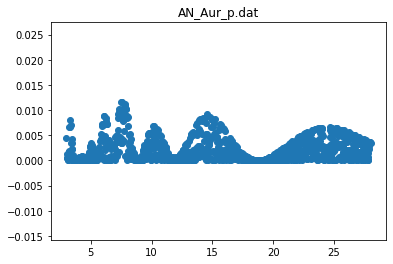

peaks are at  [ 3.37537538  4.15115115  4.82682683  6.87887888 10.90790791 14.71171171
 15.41241241 16.26326326 17.23923924 18.74074074 21.51851852 22.11911912
 24.37137137 27.92492492]


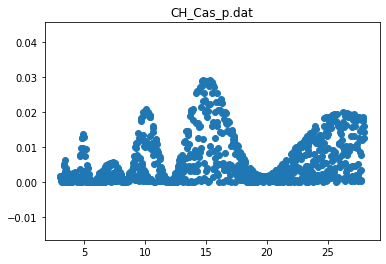

peaks are at  [ 3.32532533  5.12712713  6.05305305  7.65465465  9.75675676 10.15715716
 12.58458458 13.28528529 14.16116116 17.23923924 18.29029029 20.06706707
 21.46846847 22.09409409 27.94994995]


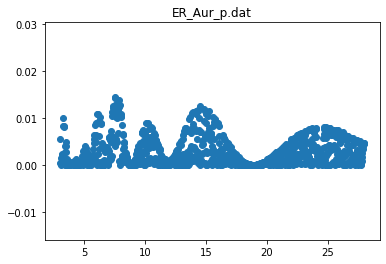

peaks are at  [ 4.12612613  4.75175175  5.62762763  7.2042042   8.83083083  9.73173173
 12.48448448 12.65965966 13.96096096 15.28728729 17.08908909 19.74174174
 21.61861862 23.94594595 24.37137137 27.54954955]


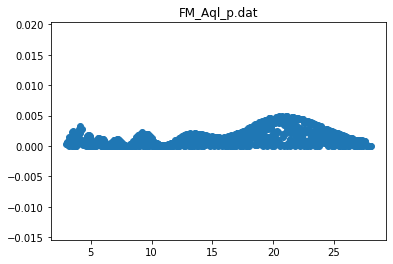

peaks are at  [ 3.1001001   3.7007007   4.42642643  5.9029029   8.03003003  8.58058058
  9.13113113 13.18518519 21.71871872 24.6966967  27.87487487]


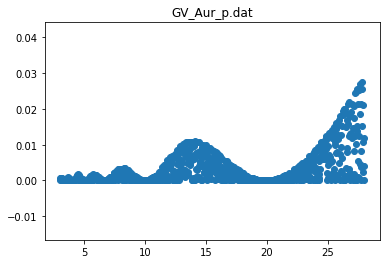

peaks are at  [ 3.22522523  3.82582583  4.8018018   5.97797798  8.28028028  8.53053053
  9.18118118 14.53653654 18.64064064 20.11711712 21.69369369 22.26926927
 24.84684685]


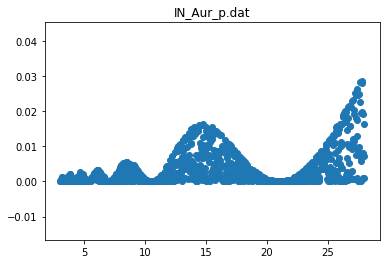

peaks are at  [ 3.35035035  4.12612613  5.3023023   6.87887888  9.75675676 13.83583584
 14.71171171 15.41241241 16.26326326 17.23923924 21.46846847 22.09409409
 27.92492492]


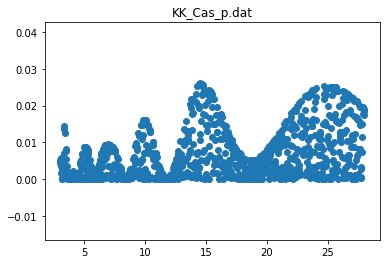

peaks are at  [ 3.5005005   4.72672673  5.8028028   7.4044044   9.75675676 10.55755756
 11.08308308 13.41041041 13.96096096 14.93693694 16.11311311 17.41441441
 18.26526527 21.61861862 27.8998999 ]


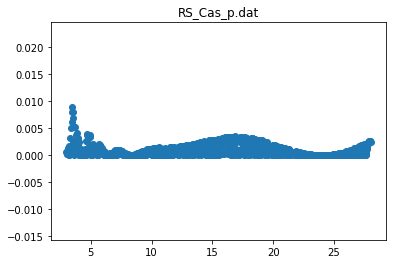

peaks are at  [ 3.32532533  5.12712713  6.05305305  7.62962963  9.75675676 10.15715716
 12.58458458 13.28528529 17.23923924 18.31531532 21.46846847 22.09409409
 24.6966967  27.94994995]


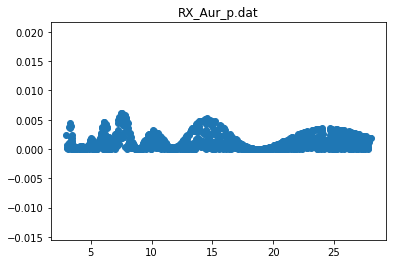

peaks are at  [ 3.05005005  3.5005005   5.2022022   6.12812813  7.92992993  9.75675676
 10.90790791 13.83583584 14.71171171 15.41241241 16.26326326 19.91691692
 21.61861862 21.96896897 24.07107107 27.92492492]


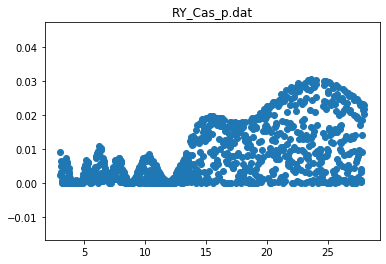

peaks are at  [ 3.45045045  3.97597598  4.75175175  5.9029029   7.2042042   7.75475475
 11.40840841 12.08408408 12.70970971 13.41041041 14.93693694 16.13813814
 17.41441441 18.26526527 19.36636637 20.06706707 21.26826827 21.96896897
 23.87087087 24.44644645 25.17217217 27.8998999 ]


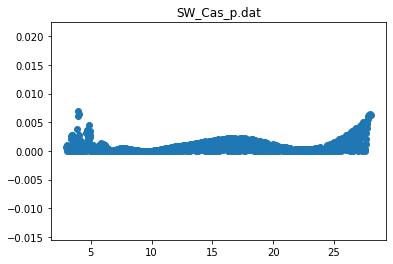

peaks are at  [ 3.22522523  3.82582583  4.77677678  5.92792793  8.35535536  8.53053053
  9.20620621 12.73473473 13.18518519 13.96096096 14.53653654 16.78878879
 17.58958959 18.64064064 20.11711712 21.69369369 24.84684685]


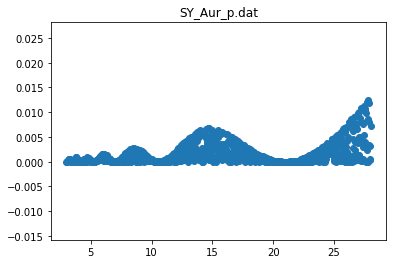

peaks are at  [ 3.27527528  4.2012012   4.92692693  5.67767768  8.03003003 10.35735736
 11.23323323 13.08508509 13.58558559 14.13613614 15.11211211 15.78778779
 16.31331331 17.86486486 18.84084084 21.89389389 24.07107107 24.74674675
 27.82482482]


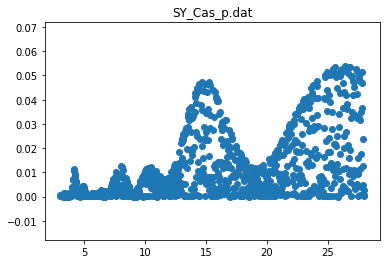

peaks are at  [ 3.55055055  4.22622623  6.17817818  9.75675676 10.38238238 10.90790791
 13.83583584 14.71171171 15.41241241 16.26326326 17.23923924 20.04204204
 21.49349349 22.14414414 27.92492492]


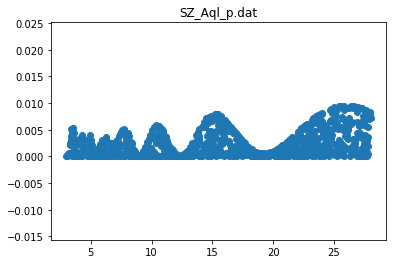

peaks are at  [ 3.37537538  4.22622623  4.85185185  6.25325325  7.95495495 13.83583584
 14.71171171 15.41241241 16.26326326 17.23923924 18.29029029 21.54354354
 22.14414414 24.37137137 27.92492492]


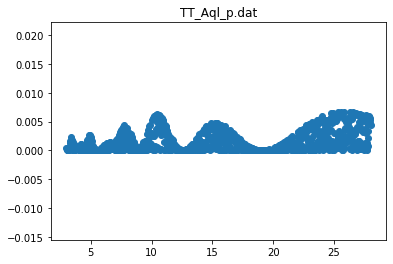

peaks are at  [ 3.05005005  4.5015015   6.9039039   7.52952953  9.53153153 10.20720721
 12.13413413 13.08508509 13.58558559 14.13613614 15.46246246 16.31331331
 17.93993994 18.81581582 20.24224224 21.94394394 24.47147147 27.74974975]


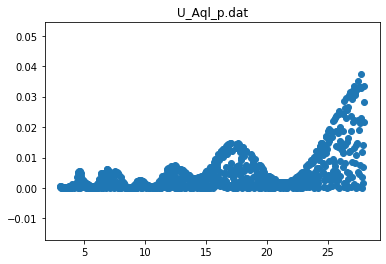

peaks are at  [ 3.45045045  4.22622623  4.92692693  6.37837838  7.52952953  8.05505506
  9.78178178 10.35735736 11.23323323 12.23423423 13.08508509 13.58558559
 14.13613614 14.98698699 15.78778779 16.31331331 18.84084084 21.89389389
 24.07107107 24.84684685 27.82482482]


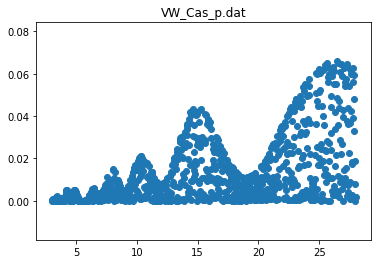

peaks are at  [ 3.3003003   4.3013013   5.15215215  7.8048048   9.75675676 10.18218218
 13.26026026 15.01201201 15.81281281 16.61361361 19.59159159 21.49349349
 22.14414414 24.6966967  27.94994995]


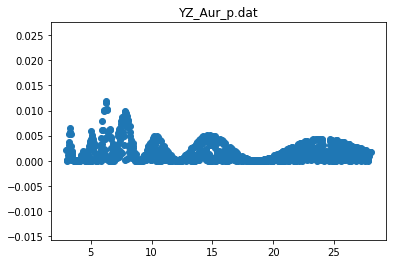

In [5]:
periods = []
for file in files:
    star = cepheid(file) #assign a class variable (not necesary, just for fun. cepheid.plot() would work just as well)
#     star.power_spectrum_plot() #can plot the power spectrum and show the location of the peaks
#     periods.append(star.parameter_estimation()[1]) #estimates the best fit parameters
#     star.plot() #plots a comparision between the orginal data and the fitted curve
    star.power_spectrum_plot()

In [1]:
import pip

In [2]:
sorted(["%s==%s" % (i.key, i.version) for i in pip.get_installed_distributions()])
import 

AttributeError: module 'pip' has no attribute 'get_installed_distributions'